по сылке не только гугл нет реализован в пайторче- https://www.programmerall.com/article/8680138266/

   https://www.programmerall.com/article/9998749730/

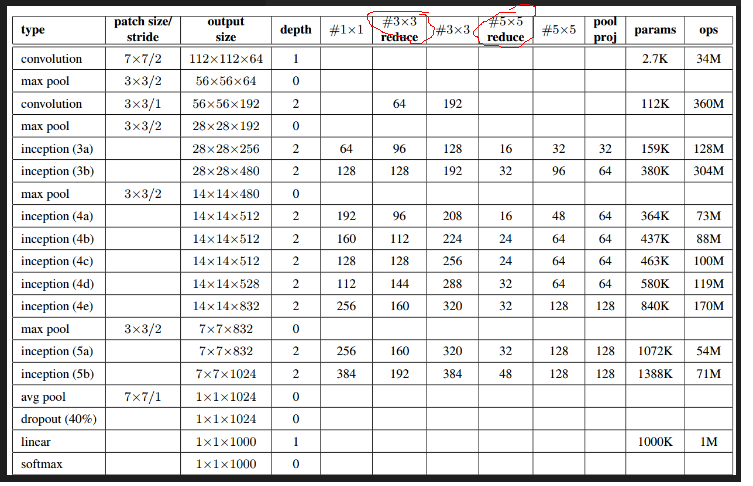

In [18]:
import warnings
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.model_zoo import load_url as load_state_dict_from_url
# from torchsummary import summary

In [19]:
class Inception(nn.Module):
    def __init__(self,in_c,c1,c2,c3,c4):
        super(Inception, self).__init__()
        self.branch1 = nn.Conv2d(in_c,c1,kernel_size=1)

        self.branch2_1 = nn.Conv2d(in_c,c2[0],kernel_size=1)
        self.branch2_2 = nn.Conv2d(c2[0],c2[1],kernel_size=3,padding=1)

        self.branch3_1 = nn.Conv2d(in_c,c3[0],kernel_size=1)
        self.branch3_2 = nn.Conv2d(c3[0],c3[1],kernel_size=5,padding=2)

        self.branch4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.branch4_2 = nn.Conv2d(in_c,c4,kernel_size=1)

    def forward(self,x):
        o1 = self.branch1(x)
        o1 = F.relu(o1)
        # print("o1:",o1.shape)

        o2 = self.branch2_1(x)
        o2 = F.relu(o2)
        o2 = self.branch2_2(o2)
        o2 = F.relu(o2)
        # print("o2:",o2.shape)

        o3 = self.branch3_1(x)
        o3 = F.relu(o3)
        o3 = self.branch3_2(o3)
        o3 = F.relu(o3)
        # print("o3:",o3.shape)

        o4 = self.branch4_1(x)
        o4 = self.branch4_2(o4)
        o4 = F.relu(o4)
        # print("o4:",o4.shape)

        concat = torch.cat((o1,o2,o3,o4),dim=1)
        # print("concat:",concat.shape)

        return concat

- - - - - - - - - - Демонстрация - - - - - - - - - -  

In [20]:
X = torch.randn((1,1,224,224))

conv1 = nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3)
max_pool1 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

o=conv1(X)
# print(o.shape) #[1,64,112,112]
o=max_pool1(o)
# print(o.shape, "\n") #[1,64,56,56]


conv2_1 = nn.Conv2d(64,64,kernel_size=1)
conv2_2 = nn.Conv2d(64,192,kernel_size=3,stride=1,padding=1)
max_pool2 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

o=conv2_1(o)
# print(o.shape) #[1,64,56,56]
o=conv2_2(o)
# print(o.shape) #[1,192,56,56]
o=max_pool2(o)
# print(o.shape) #[1,192,28,28]

- - - - - - - - - - Демонстрация - - - - - - - - - -

In [21]:
class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet,self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64,64,kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64,192,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
        )

        self.inception_3a = Inception(192,64,(96,128),(16,32),32)
        self.inception_3b = Inception(256,128,(128,192),(32,96),64)
        self.max_pool3 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.inception_4a = Inception(480,192,(96,208),(16,48),64)
        self.inception_4b = Inception(512,160,(112,224),(24,64),64)
        self.inception_4c = Inception(512,128,(128,256),(24,64),64)
        self.inception_4d = Inception(512,112,(144,288),(32,64),64)
        self.inception_4e = Inception(528,256,(160,320),(32,128),128)
        self.max_pool4 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.inception_5a = Inception(832,256,(160,320),(32,128),128)
        self.inception_5b = Inception(832,384,(192,384),(48,128),128)

        self.avg_pool = nn.AvgPool2d(kernel_size=7)
        self.dropout = nn.Dropout(p=0.4)

        self.fc = nn.Linear(1024,10,bias=True)

    def forward(self,x):
        feature = self.conv1(x)
        feature = self.conv2(feature)

        feature = self.inception_3a(feature)
        feature = self.inception_3b(feature)
        feature = self.max_pool3(feature)

        feature = self.inception_4a(feature)
        feature = self.inception_4b(feature)
        feature = self.inception_4c(feature)
        feature = self.inception_4d(feature)
        feature = self.inception_4e(feature)
        feature = self.max_pool4(feature)

        feature = self.inception_5a(feature)
        feature = self.inception_5b(feature)

        feature = self.avg_pool(feature)
        feature = self.dropout(feature)

        out = self.fc(feature.view(x.shape[0],-1))

        return out

- - - - - - - - - - Демонстрация - - - - - - - - - -  :

In [22]:
X=torch.randn((1,1,224,224))
net = GoogLeNet()
# for name,module in net.named_children():
#     X=module(X)
#     print(name,X.shape)

out = net(X)
print(out.shape)

torch.Size([1, 10])


- - - - - - - - - - Демонстрация - - - - - - - - - -  :


- - - - - - - - - -Как тестить слои нейросети

Приведенный выше код только выглядит сложным, на самом деле реализовать структуру GoogLeNet, описанную на предыдущем рисунке, несложно. Например, сначала напишите ее

In [23]:
class GoogDebugLeNet(nn.Module):
    def __init__(self):
        super(GoogDebugLeNet,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
        )

In [24]:
X=torch.randn((1,1,224,224))
net = GoogDebugLeNet()
for name,module in net.named_children():
    X=module(X)
    # print(name,X.shape)

In [25]:
class GoogDebugLeNet(nn.Module):
    def __init__(self):
        super(GoogDebugLeNet,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64,64,kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64,192,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
        )

In [26]:
X=torch.randn((1,1,224,224))
net = GoogDebugLeNet()
for name,module in net.named_children():
    X=module(X)
    print(name,X.shape)

conv1 torch.Size([1, 64, 56, 56])
conv2 torch.Size([1, 192, 28, 28])


- - - - - - - - - -Как тестить слои нейросети

In [56]:
batch_size,num_workers=16,1

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

trans = transforms.Compose([transforms.ToTensor(), transforms.Resize(224)])

train_dataset = datasets.MNIST(root = 'data/', train = True, transform = trans, download=True)
test_dataset = datasets.MNIST(root='data/', train=False, transform=trans, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers = num_workers)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers = num_workers)

# train_iter = learntorch_utils.load_data(batch_size,num_workers,resize=224)
# test_iter = learntorch_utils.load_data(batch_size,num_workers,resize=224)

In [57]:
net = GoogLeNet().cuda()
# print(net)

In [58]:
loss = nn.CrossEntropyLoss()

In [59]:
opt = torch.optim.Adam(net.parameters(),lr=0.001)

In [69]:
import time

def test():
    start = time.time()
    acc_sum = 0
    batch = 0
#     print("test.....")
    
    for X,y in test_loader:
#         print("1.....")
        X,y = X.cuda(),y.cuda()
#         print("2.....")
        y_hat = net(X)
#         print("3.....")
        acc_sum += (y_hat.argmax(dim=1) == y).float().sum().item()
#         print("4.....")
        batch += 1
#         print("5.....")
    print('acc_sum %d,batch %d' % (acc_sum,batch))

    acc = 1.0*acc_sum/(batch*batch_size)
    end = time.time()
    print('acc %3f,test for test dataset:time %d' % (acc,end - start))

    return acc

In [72]:
num_epochs = 3
save_to_disk = False

def train():
    counter = 0
    for epoch in range(num_epochs):
        train_l_sum, batch, acc_sum = 0,0,0
        start = time.time()
        
        for X,y in train_loader:
            start_batch_begin = time.time()
            X,y = X.cuda(),y.cuda()
            y_hat = net(X)
            acc_sum += (y_hat.argmax(dim=1) == y).float().sum().item()

            l = loss(y_hat,y)
            opt.zero_grad()
            l.backward()

            opt.step()
            train_l_sum += l.item()

            batch += 1

            mean_loss = train_l_sum/(batch*batch_size) #Calculate the average loss to each picture
            start_batch_end = time.time()
            time_batch = start_batch_end - start

            train_acc = acc_sum/(batch*batch_size)
            if batch % 100 == 0:
                print('f epoch %d,batch %d,train_loss %.3f,train_acc:%.3f,time %.3f' %
                    (epoch,batch,mean_loss,train_acc,time_batch))
                print('***************************************')

            # if save_to_disk and batch % 1000 == 0:
            #     model_state = net.state_dict()
            #     model_name = 'nin_epoch_%d_batch_%d_acc_%.2f.pt' % (epoch,batch,train_acc)
            #     torch.save(model_state,model_name)

        mean_loss = train_l_sum/(batch*batch_size) #Calculate the average loss to each picture
        train_acc = acc_sum/(batch*batch_size) #Calculate training accuracy
        test_acc = test() #Calculate test accuracy

        counter += 1
        if counter > 1000 : break

        end = time.time()
        time_per_epoch =  end - start
        print('epoch %d,train_loss %f,train_acc %f,test_acc %f,time %f' %
                (epoch + 1,mean_loss,train_acc,test_acc,time_per_epoch))



In [73]:
train()

f epoch 0,batch 100,train_loss 0.144,train_acc:0.113,time 4.830
***************************************
f epoch 0,batch 200,train_loss 0.144,train_acc:0.112,time 6.886
***************************************
f epoch 0,batch 300,train_loss 0.144,train_acc:0.111,time 8.948
***************************************
f epoch 0,batch 400,train_loss 0.144,train_acc:0.112,time 10.991
***************************************
f epoch 0,batch 500,train_loss 0.144,train_acc:0.113,time 13.000
***************************************
f epoch 0,batch 600,train_loss 0.144,train_acc:0.113,time 15.034
***************************************
f epoch 0,batch 700,train_loss 0.144,train_acc:0.113,time 17.038
***************************************
f epoch 0,batch 800,train_loss 0.144,train_acc:0.113,time 19.026
***************************************
f epoch 0,batch 900,train_loss 0.144,train_acc:0.113,time 21.029
***************************************
f epoch 0,batch 1000,train_loss 0.144,train_acc:0.113,time

f epoch 2,batch 200,train_loss 0.144,train_acc:0.112,time 6.550
***************************************
f epoch 2,batch 300,train_loss 0.144,train_acc:0.111,time 8.562
***************************************
f epoch 2,batch 400,train_loss 0.144,train_acc:0.112,time 10.561
***************************************
f epoch 2,batch 500,train_loss 0.144,train_acc:0.113,time 12.552
***************************************
f epoch 2,batch 600,train_loss 0.144,train_acc:0.113,time 14.545
***************************************
f epoch 2,batch 700,train_loss 0.144,train_acc:0.113,time 16.538
***************************************
f epoch 2,batch 800,train_loss 0.144,train_acc:0.113,time 18.533
***************************************
f epoch 2,batch 900,train_loss 0.144,train_acc:0.112,time 20.494
***************************************
f epoch 2,batch 1000,train_loss 0.144,train_acc:0.113,time 22.500
***************************************
f epoch 2,batch 1100,train_loss 0.144,train_acc:0.114,ti